In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the data
df = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',')

# Data Cleaning with fixed datetime parsing
def clean_data(df):
    # Fix time format by replacing dots with colons
    df['Time'] = df['Time'].str.replace('.', ':')

    # Convert Date and Time to datetime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # Replace -200 (missing values) with NaN
    df.replace(-200, np.nan, inplace=True)

    # Drop empty columns and rows
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    # Forward fill missing values for short gaps
    df.fillna(method='ffill', limit=2, inplace=True)

    # Backward fill remaining missing values
    df.fillna(method='bfill', inplace=True)

    return df

df = clean_data(df)


In [5]:
# Feature Engineering
def engineer_features(df):
    # Extract time-based features
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    df['DayOfYear'] = df['DateTime'].dt.dayofyear

    # Calculate rolling averages for key pollutants
    pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'PT08.S5(O3)']
    for pol in pollutants:
        df[f'{pol}_3h_avg'] = df[pol].rolling(window=3, min_periods=1).mean()
        df[f'{pol}_24h_avg'] = df[pol].rolling(window=24, min_periods=1).mean()

    # Calculate AQI (simplified version)
    def calculate_aqi(row):
        # Simplified AQI calculation based on CO, NO2, and O3
        co = row['CO(GT)']
        no2 = row['NO2(GT)']
        o3 = row['PT08.S5(O3)']

        # Normalize and weight the pollutants
        aqi = (co*0.4 + no2*0.3 + o3*0.3) * 10
        return aqi

    df['AQI'] = df.apply(calculate_aqi, axis=1)

    # Categorize AQI
    bins = [0, 50, 100, 150, 200, 300, 500]
    labels = ['Good', 'Moderate', 'Unhealthy(Sensitive)', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    df['AQI_Category'] = pd.cut(df['AQI'], bins=bins, labels=labels)

    return df

df = engineer_features(df)

In [6]:
# Visualization Functions
def plot_pollutants(df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # CO
    axes[0].plot(df['DateTime'], df['CO(GT)'], color='blue')
    axes[0].set_title('CO Levels Over Time')
    axes[0].set_ylabel('CO (mg/m³)')

    # NO2
    axes[1].plot(df['DateTime'], df['NO2(GT)'], color='green')
    axes[1].set_title('NO2 Levels Over Time')
    axes[1].set_ylabel('NO2 (µg/m³)')

    # O3
    axes[2].plot(df['DateTime'], df['PT08.S5(O3)'], color='red')
    axes[2].set_title('O3 Levels Over Time')
    axes[2].set_ylabel('O3 (µg/m³)')
    axes[2].set_xlabel('Date')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_hourly_patterns(df):
    plt.figure(figsize=(15, 8))

    # CO
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Hour', y='CO(GT)', data=df)
    plt.title('Hourly CO Distribution')

    # NO2
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Hour', y='NO2(GT)', data=df)
    plt.title('Hourly NO2 Distribution')

    # O3
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Hour', y='PT08.S5(O3)', data=df)
    plt.title('Hourly O3 Distribution')

    # AQI
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Hour', y='AQI', data=df)
    plt.title('Hourly AQI Distribution')

    plt.tight_layout()
    plt.show()

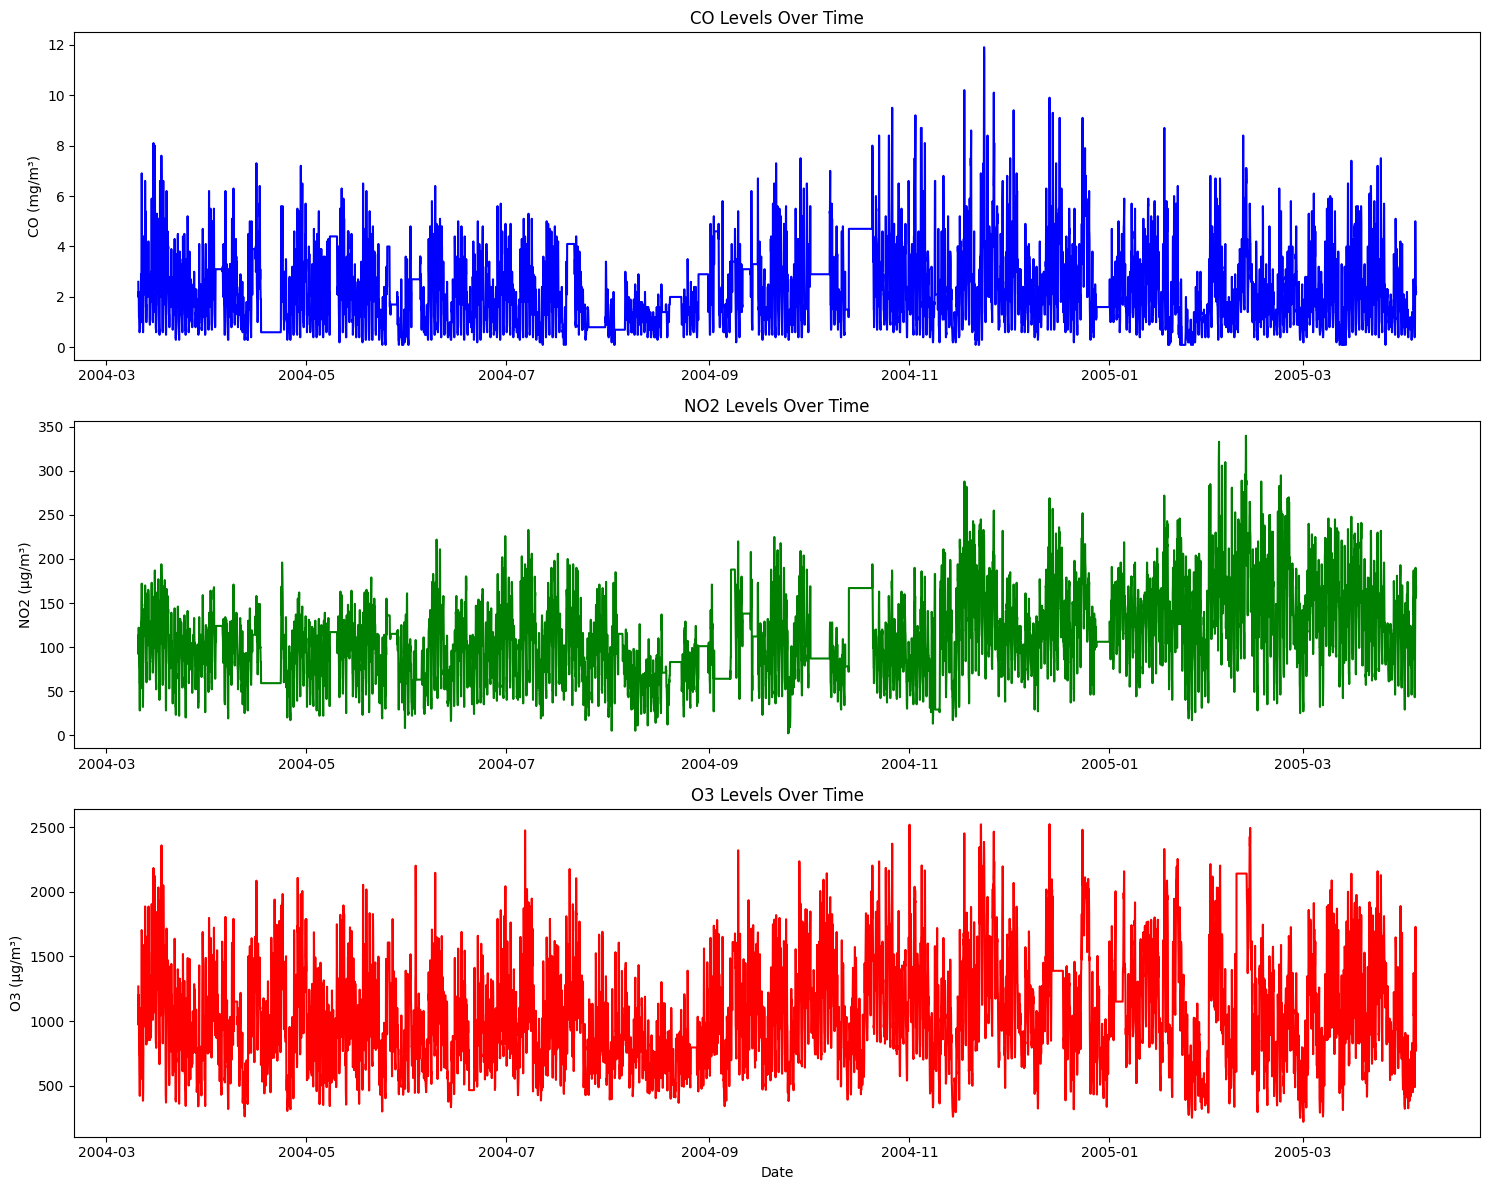

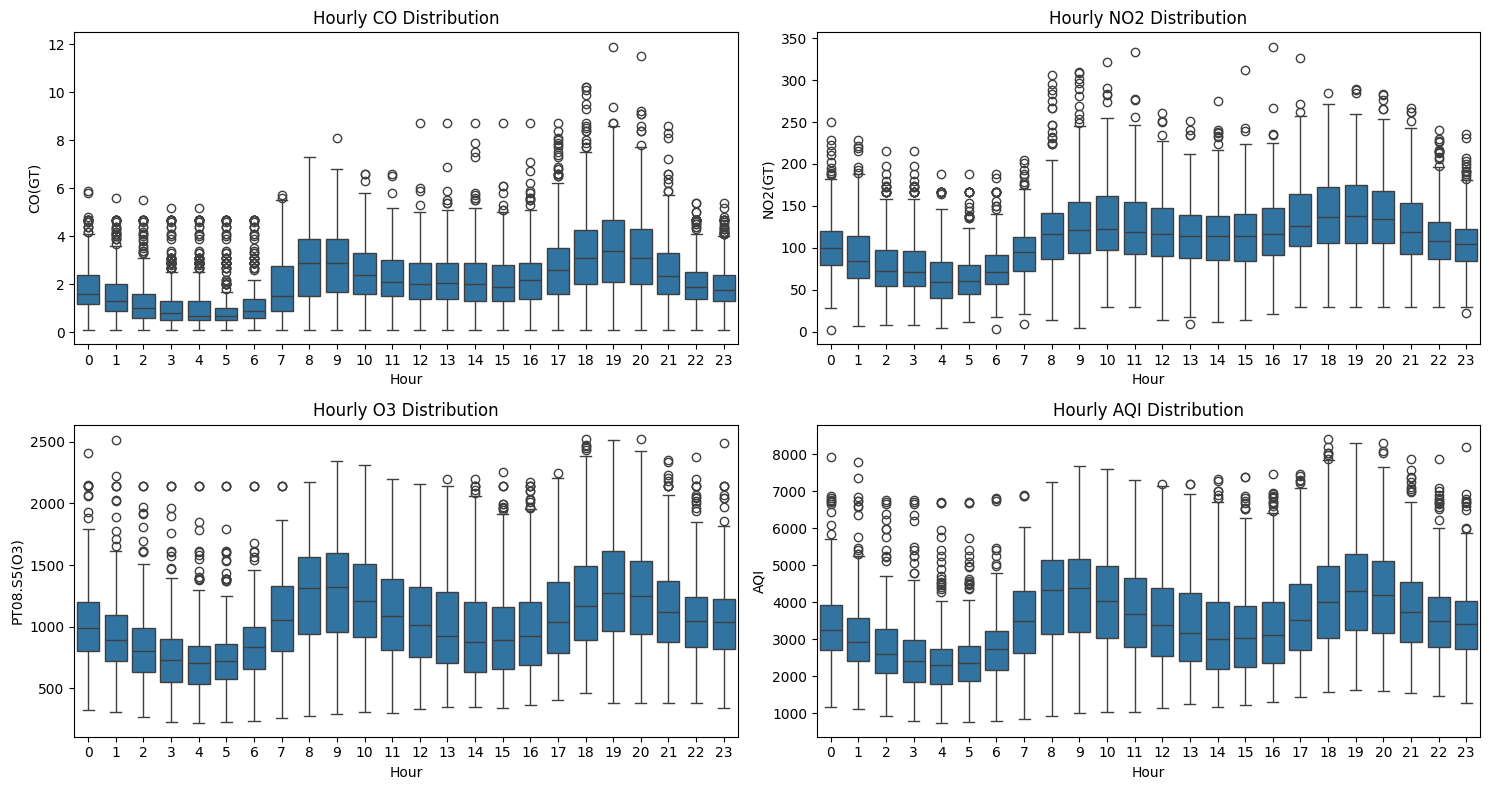

In [8]:
# Run visualizations
plot_pollutants(df)
plot_hourly_patterns(df)


In [9]:
# Prepare data for modeling
def prepare_data(df, target='AQI', forecast_horizon=3):
    features = [
        'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
        'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
        'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month',
        'CO(GT)_3h_avg', 'NO2(GT)_3h_avg', 'PT08.S5(O3)_3h_avg',
        'CO(GT)_24h_avg', 'NO2(GT)_24h_avg', 'PT08.S5(O3)_24h_avg'
    ]

    df['target'] = df[target].shift(-forecast_horizon)
    df = df.dropna(subset=['target'])

    X = df[features]
    y = df['target']

    return X, y

X, y = prepare_data(df)

In [10]:
# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Model Evaluation Metrics:
R² Score: 0.8083
Mean Absolute Error: 441.9127
Root Mean Squared Error: 593.5222


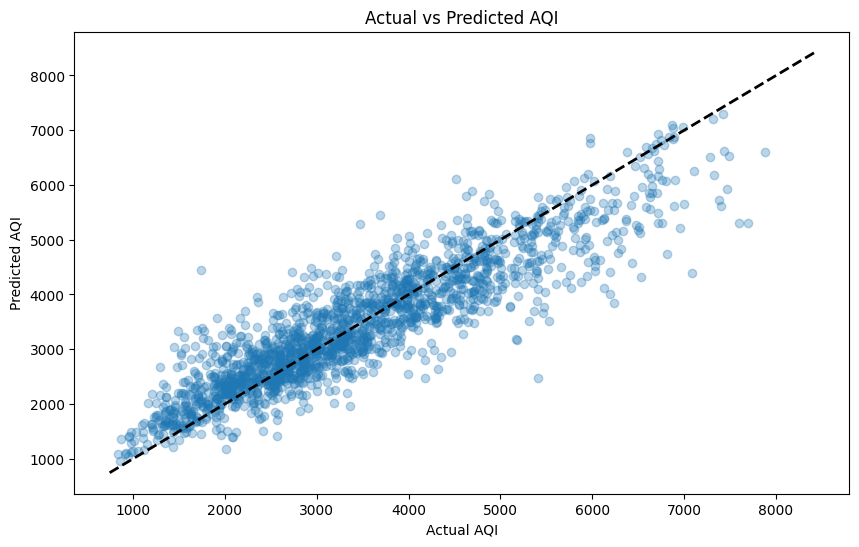

In [11]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"Model Evaluation Metrics:")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title('Actual vs Predicted AQI')
    plt.show()

    return y_pred

y_pred = evaluate_model(best_model, X_test, y_test)


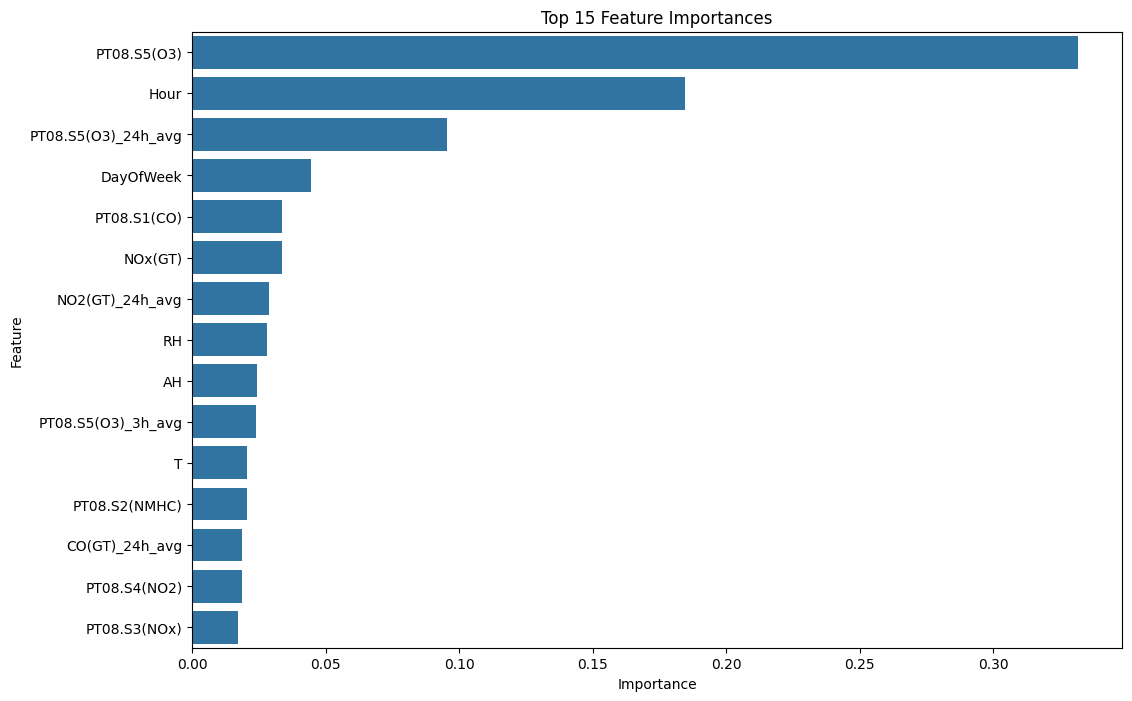

In [12]:
# Feature importance
def plot_feature_importance(model, X):
    feature_importances = model.named_steps['model'].feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.show()

plot_feature_importance(best_model, X)



=== AIR QUALITY ALERTS ===
ALERT: High AQI (8415.6) detected at 2004-12-13 18:00:00. Category: nan


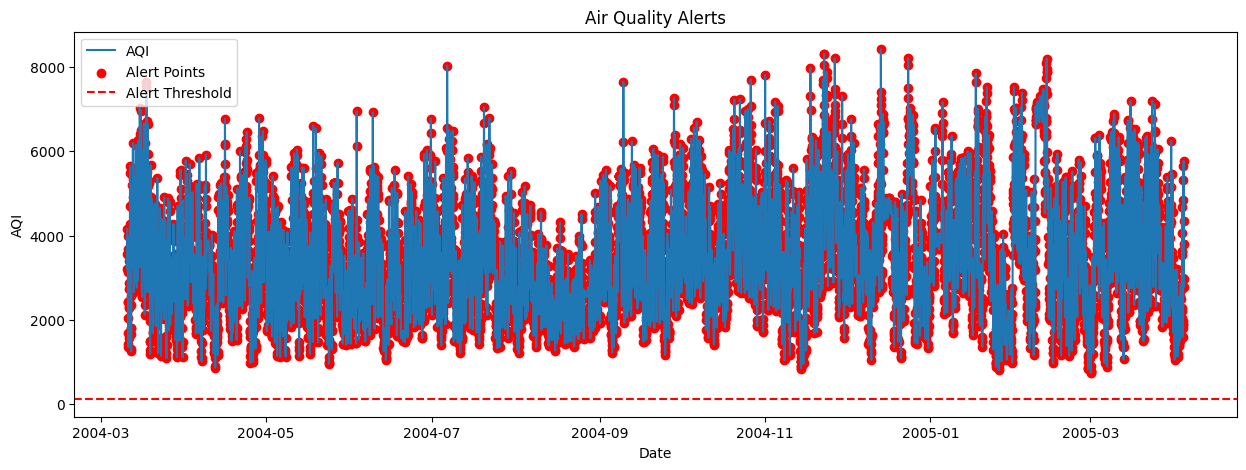


Air quality analysis completed successfully!


In [13]:
# Sensitive area detection and alert system
def identify_sensitive_areas(df, threshold=100):
    df['Sensitive'] = df['AQI'] > threshold
    df['Sensitivity_Score'] = df['AQI'].rolling(window=6).mean()
    return df

df = identify_sensitive_areas(df)

def generate_alerts(df, alert_threshold=120):
    alerts = df[df['AQI'] > alert_threshold].copy()

    if not alerts.empty:
        alerts['Alert_Message'] = alerts.apply(
            lambda row: f"ALERT: High AQI ({row['AQI']:.1f}) detected at {row['DateTime']}. Category: {row['AQI_Category']}",
            axis=1
        )

        alerts['Group'] = (alerts['DateTime'].diff() > pd.Timedelta('1h')).cumsum()
        grouped_alerts = alerts.loc[alerts.groupby('Group')['AQI'].idxmax()]

        print("\n=== AIR QUALITY ALERTS ===")
        for _, alert in grouped_alerts.iterrows():
            print(alert['Alert_Message'])

        plt.figure(figsize=(15, 5))
        plt.plot(df['DateTime'], df['AQI'], label='AQI')
        plt.scatter(alerts['DateTime'], alerts['AQI'], color='red', label='Alert Points')
        plt.axhline(y=alert_threshold, color='r', linestyle='--', label='Alert Threshold')
        plt.title('Air Quality Alerts')
        plt.ylabel('AQI')
        plt.xlabel('Date')
        plt.legend()
        plt.show()
    else:
        print("No air quality alerts currently.")

    return grouped_alerts

alerts = generate_alerts(df)

# Save results
alerts[['DateTime', 'AQI', 'AQI_Category', 'Alert_Message']].to_csv('air_quality_alerts.csv', index=False)

print("\nAir quality analysis completed successfully!")

In [15]:
# Feature Engineering
def engineer_features(df):
    # Extract time-based features
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    df['DayOfYear'] = df['DateTime'].dt.dayofyear

    # Calculate rolling averages for key pollutants
    pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'PT08.S5(O3)']
    for pol in pollutants:
        df[f'{pol}_3h_avg'] = df[pol].rolling(window=3, min_periods=1).mean()
        df[f'{pol}_24h_avg'] = df[pol].rolling(window=24, min_periods=1).mean()

    # Calculate AQI (simplified version)
    def calculate_aqi(row):
        # Simplified AQI calculation based on CO, NO2, and O3
        co = row['CO(GT)']
        no2 = row['NO2(GT)']
        o3 = row['PT08.S5(O3)']

        # Normalize and weight the pollutants
        aqi = (co*0.4 + no2*0.3 + o3*0.3) * 10
        return aqi

    df['AQI'] = df.apply(calculate_aqi, axis=1)

    # Categorize AQI
    bins = [0, 50, 100, 150, 200, 300, 500]
    labels = ['Good', 'Moderate', 'Unhealthy(Sensitive)', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    df['AQI_Category'] = pd.cut(df['AQI'], bins=bins, labels=labels)

    return df

df = engineer_features(df)

Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 13101267.0000 - mae: 3394.9006 - val_loss: 15290793.0000 - val_mae: 3568.5789
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 12573783.0000 - mae: 3319.8950 - val_loss: 14545046.0000 - val_mae: 3462.5156
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 11704736.0000 - mae: 3189.8191 - val_loss: 13466407.0000 - val_mae: 3303.0852
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 10565686.0000 - mae: 3004.8677 - val_loss: 11954298.0000 - val_mae: 3065.6572
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 9127201.0000 - mae: 2751.8801 - val_loss: 10154042.0000 - val_mae: 2756.9753
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 7541394.5000 - mae: 2450.2610 - val_loss: 8396186.0000 - val_mae: 2427.6313
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 5988857.0000 - mae: 2113.9299 - val_loss: 6805462.5000 - val_mae: 2108.7769
Epoch 8/100
234/234 ━━━━

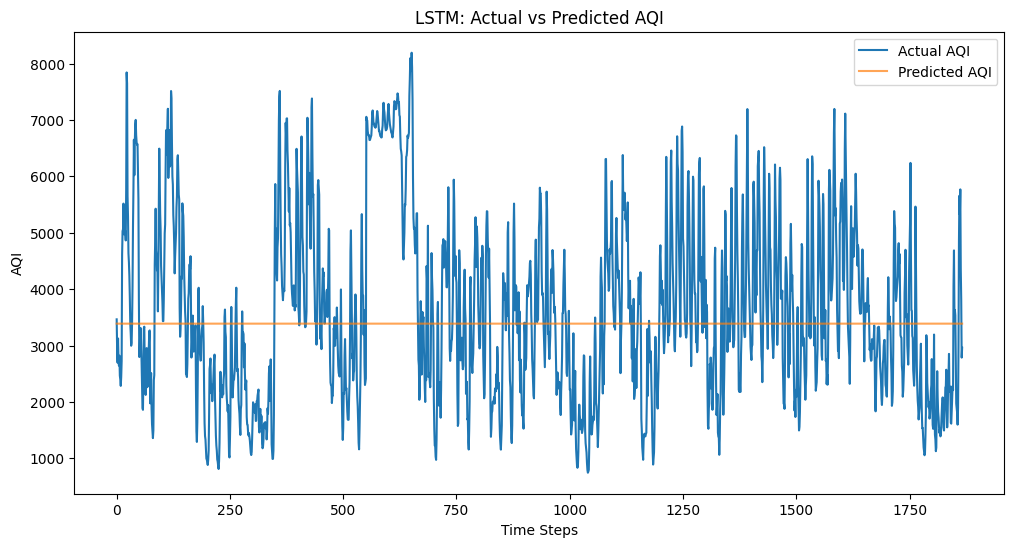

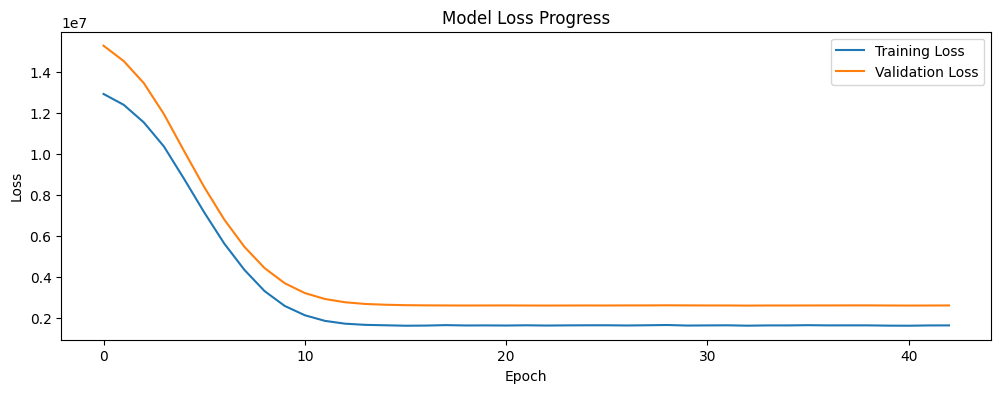

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data for LSTM
def prepare_lstm_data(df, target='AQI', n_steps=24):
    # Scale features
    scaler = MinMaxScaler()
    features = ['CO(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
    scaled_data = scaler.fit_transform(df[features])

    # Prepare sequences
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i])
        y.append(df[target].iloc[i])
    X, y = np.array(X), np.array(y)

    return X, y, scaler

# Create sequences with 24 hours lookback
X, y, scaler = prepare_lstm_data(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Get input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize model
lstm_model = build_lstm_model(input_shape)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model
def evaluate_lstm_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"LSTM Model Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual AQI')
    plt.plot(y_pred, label='Predicted AQI', alpha=0.7)
    plt.title('LSTM: Actual vs Predicted AQI')
    plt.xlabel('Time Steps')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return y_pred

y_pred_lstm = evaluate_lstm_model(lstm_model, X_test, y_test)

# Function to make future predictions
def predict_future_aqi(model, last_sequence, scaler, features, steps=24):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Reshape for model input
        input_data = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

        # Predict next AQI
        pred = model.predict(input_data)[0][0]
        future_predictions.append(pred)

        # Update sequence (we don't have future features in real scenario)
        # In practice, you would get new feature values from sensors
        new_features = current_sequence[-1, :-1]  # Repeat last known features
        new_row = np.append(new_features, pred)
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return future_predictions

